# Deep Residual Learning for Audio Recogniton <br>

Author: Jamie McQuire <br>

* This notebook is for the 6-word vocabulary dataset.
* This notebook is going to implement a ResNet network for the classifiation of the spectrogram images.
* This [tutorial](https://www.youtube.com/watch?v=wqkc-sj5H94) helped build the model.
* This model will be trained using the image data from the pre-processing notebook.
* Upload this notebook to google colab for faster computing with a GPU.
* If you wish to repeat this analysis please upload the notebook to google drive (directories must be set appropriately).

In [1]:
#import libraries
import os
import numpy as np
import tensorflow as tf
import keras
import seaborn as sn
from keras import layers
from keras.initializers import glorot_uniform
from keras.layers import Input, Add, Dense, Activation, Dropout, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import to_categorical

Using TensorFlow backend.


* Mount the google drive where you should have the data stored.
* Alternatively load the data into your working directory.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* Load in the training, validation, and testing data from your specified directory.
* Change the directory to repeat the analysis.

In [0]:
#load in the training data and labels
X_train = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/X_train.npy")
Y_train = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/Y_train.npy")

#load in the validation data and labels
X_val = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/X_val.npy")
Y_val = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/Y_val.npy")

X_test = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/X_test.npy")
Y_test = np.load("/content/drive/My Drive/Tensor_Flow_Speech_Recognition_Challenge/data/Y_test.npy")

* These are the default settings.
* Check that the image_size = (161,99,1).


In [0]:
batch_size = 128
epochs = 10
image_size = X_train.shape[1:]
output_size = 6

print(image_size)

(161, 99, 1)


* Scale the image pixel data for the deep learning models.

In [0]:
#scale the training data
X_train_scaled = X_train * (1 / 255)
X_val_scaled = X_val * (1  / 255)
X_test_scaled = X_test * (1 / 255)

* Convert the labels to one-hot-encoded vectors.

In [0]:
Y_train = to_categorical(Y_train,num_classes=output_size)
Y_val = to_categorical(Y_val,num_classes=output_size)
Y_test = to_categorical(Y_test,num_classes=output_size)

* This function will define the architecture of the identity block.

In [0]:
#building the identity block of the ResNet

def identity_block(X,f,filters,stage,block):
    
    #this is the function for the identity block
    #X is the input tensor
    #f is the filter shape for the middle block
    #filters is the list containing the filter sizes (int)
    #stage names the layer relative to the position in the network
    #block is used to name the layers 
    
    #name definition
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    #filters 1,2,3
    f1, f2, f3 = filters
    
    #initial value
    X_shortcut = X
    
    #define the first component block 
    X = Conv2D(filters=f1, kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2a",kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)
    
    #second component block 
    X = Conv2D(filters=f2, kernel_size=(f,f),strides=(1,1),padding="same",name=conv_name_base+"2b",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base + "2b")(X)
    X = Activation("relu")(X)
    
    #third component block 
    X = Conv2D(filters=f3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2c",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base + "2c")(X)
    
    #make the connection at the add block 
    X = Add()([X,X_shortcut])
    #finish with the relu activation layer
    X = Activation("relu")(X)
    
    #return the new value of X
    return X

* This function will define the architecture of the convolutional block.

In [0]:
def convolution_block(X,f,filters,stage,block,s=2):
    
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base = "bn" + str(stage) + block + "_branch"
    
    f1, f2, f3 = filters
    
    #initialize the value of X
    X_shortcut = X
    
    #the branch from the main path
    X_filt3 = Conv2D(f3,(1,1),strides=(s,s),name=conv_name_base+"1",kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_filt3 = BatchNormalization(axis=3,name=bn_name_base + "1")(X_filt3)
    
    #main path
    
    #block 1
    X = Conv2D(f1,kernel_size=(1,1),strides=(s,s),name=conv_name_base+"2a",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2a")(X)
    X = Activation("relu")(X)
    
    #block 2
    X = Conv2D(f2,kernel_size=(f,f),strides=(1,1),padding="same",name=conv_name_base+"2b",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    
    #block 3
    X = Conv2D(f3,kernel_size=(1,1),strides=(1,1),padding="valid",name=conv_name_base+"2c",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name=bn_name_base+"2c")(X)
    
    #add the branch and the main path together
    X = Add()([X,X_filt3])
    
    #finish with a relu
    X = Activation("relu")(X) 
    
    #return the new value of X
    return X

* This function will define the architecture of the ResNet model.
* Change the hyper-parameters to change the results.

In [0]:
def ResNet50(input_shape=(161,99,1), num_classes=6):
    
    X_input = Input(input_shape)
    
    #padding
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage1
    X = Conv2D(64, (7,7),strides=(2,2),name="conv1",kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3,name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D((3,3),strides=(2,2))(X)

    X = Dropout(0.25)(X)
    
    #stage2
    X = convolution_block(X,f=3,filters=[64,64,256],stage=2,s=1,block="a")
    X = identity_block(X,f=3,filters=[64,64,256],stage=2,block="b")
    X = identity_block(X,f=3,filters=[64,64,256],stage=2,block="c")

    X = Dropout(0.25)(X)
    
    #stage3
    X = convolution_block(X,f=3,filters=[128,128,512],stage=3,s=2,block="a")
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block="b")
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block="c")
    X = identity_block(X,f=3,filters=[128,128,512],stage=3,block="d")

    X = Dropout(0.25)(X)
    
    #stage4
    X = convolution_block(X,f=3,filters=[256,256,1024],stage=4,s=2,block="a")
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block="b")
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block="c")
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block="d")
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block="e")
    X = identity_block(X,f=3,filters=[256,256,1024],stage=4,block="f")

    X = Dropout(0.25)(X)
    
    #stage5
    X = convolution_block(X,f=3,filters=[512,512,2048],stage=5,s=2,block="a")
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block="b")
    X = identity_block(X,f=3,filters=[512,512,2048],stage=5,block="c")

    X = Dropout(0.25)(X)
    
    #stage6
    X = AveragePooling2D(pool_size=(2,2),name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(num_classes,activation="softmax",name="fc"+str(num_classes))(X)
    
    model = Model(inputs=X_input,outputs=X,name="ResNet50")
    
    return model

* Create the model and compile.
* Summary should provide information about the model's layers.

In [0]:
model = ResNet50(input_shape=(161,99,1),num_classes=6)

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 161, 99, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 167, 105, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 81, 50, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 81, 50, 64)   256    

* Train the model over the specified settings.

In [0]:
history = model.fit(X_train_scaled,Y_train,epochs=20,validation_data=(X_val_scaled,Y_val),
                    batch_size=128,shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10228 samples, validate on 2557 samples
Epoch 1/20
10228/10228 [==============================] - 39s 4ms/step - loss: 2.1997 - acc: 0.1788 - val_loss: 3.4623 - val_acc: 0.1713
Epoch 2/20
10228/10228 [==============================] - 25s 2ms/step - loss: 1.7133 - acc: 0.3687 - val_loss: 12.6643 - val_acc: 0.1596
Epoch 3/20
10228/10228 [==============================] - 25s 2ms/step - loss: 0.9661 - acc: 0.6859 - val_loss: 1.4972 - val_acc: 0.5538
Epoch 4/20
10228/10228 [==============================] - 25s 2ms/step - loss: 0.4804 - acc: 0.8497 - val_loss: 0.3843 - val_acc: 0.8647
Epoch 5/20
10228/10228 [==============================] - 24s 2ms/step - loss: 0.2643 - acc: 0.9077 - val_loss: 0.2059 - val_acc: 0.9269
Epoch 6/20
10228/10228 [==============================] - 25s 2ms/step - loss: 0.1830 - acc: 0.9362 - val_loss: 0.2843 - val_acc: 0.9108
Epoch 7/20
10228/10228 [========

* Evaluate the model's performance on the testing set.

In [0]:
scores = model.evaluate(X_test_scaled,Y_test,verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.24407285200109544
Test accuracy: 0.94018296973962


* Code to plot the accuracy of the training and validation sets during model training.
* Will save to a PDF figure in the working environment.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


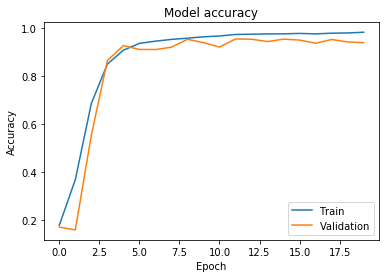

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='bottom right')
fig = plt.gcf()
fig.savefig("6_Vocab_ResNet_acc.pdf")
plt.show()

* Code to plot the loss of the training and validation sets during model training.
* Will save to a PDF figure in the working environment.

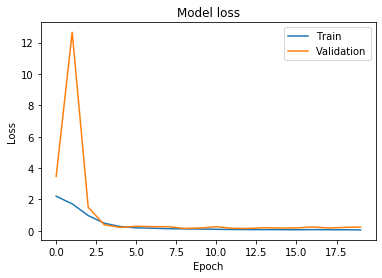

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
fig = plt.gcf()
fig.savefig("6_Vocab_ResNet_loss.pdf")
plt.show()

* Plot of a confusion matrix to view how the model classifies each voice command.
* Will save the output to a PDF in the working environment.

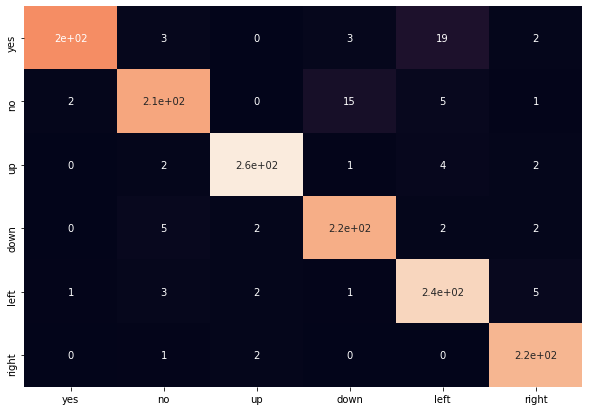

In [0]:
Y_pred = model.predict(X_test_scaled)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(Y_test,axis=1)
conf_mat = confusion_matrix(y_true,y_pred)
labs = ["yes","no","up","down","left","right"]

df_conf_mat = pd.DataFrame(conf_mat, index = [i for i in labs],
                  columns = [i for i in labs])
plt.figure(figsize = (10,7))
sn.heatmap(df_conf_mat, annot=True,cbar=False)
fig = plt.gcf()
fig.savefig("6_Vocab_ResNet_cmap.pdf",bbox_inches="tight")